In [185]:
import numpy as np
import scipy.linalg as linalg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import mne
# import yasa
import sklearn.metrics as metrics
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline
# from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from pyriemann.estimation import Covariances
# from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
# from pyriemann.classification import TSclassifier, MDM, FgMDM, KNearestNeighbor
from pyriemann.clustering import Potato, PotatoField
from pyriemann.embedding import Embedding
import pickle as pkl
from tqdm import tqdm
from copy import deepcopy

from data_util import (
    load_subjects,
    load_subject_data,
    load_data,
    euclidean_alignment,
    label_alignment,
)

# from fbcsp import FBCSP

In [2]:
data_dir = "../data/vin/Official"

In [3]:
%%time
# fmt: off
# subjects = [
#     # 'K299', 'K300', 
#     'K309', 'K310', 'K311', 'K312', 'K313', 
#     'K314', 'K315', 'K316', 'K318', 'K319', 
#     'K320', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K327', 'K328', 'K329', 
#     'K330', 'K331', 'K332', 'K333', 'K334', 
#     'K335', 'K336', 'K337', 'K338', 'K339', 
#     'K340', 'K342', 'K343', 'K344', 'K350', 
#     'K351', 'K352', 'K353', 'K354', 'K355', 
#     'K356', 'K357', 'K358', 'K359', 'K360', 
#     'K361', 'K362', 'K363', 'K364', 'K365', 
#     'K366', 'K367', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

# subjects = [
#     'K309', 'K311', 'K312', 'K313', 'K315', 
#     'K316', 'K321', 'K322', 'K323', 'K324', 
#     'K325', 'K326', 'K328', 'K329', 'K337', 
#     'K338', 'K339', 'K358', 'K359', 'K360', 
#     'K361', 'K365', 'K366', 'K367', 'K368', 
#     'K369', 'K370', 'K371', 'K372', 'K375',
# ]

subjects = [
    'K309', 'K311', 'K312', 'K313', 'K315', 
    'K316', 'K320', 'K321', 'K322', 'K323', 
    'K324', 'K325', 'K326', 'K327', 'K328', 
    'K329', 'K330', 'K337', 'K339', 'K354', 
    'K355', 'K358', 'K359', 'K360', 'K361', 
    'K362', 'K365', 'K366', 'K368', 'K369', 
    'K370', 'K371', 'K372', 'K374', 'K375',
]

# use_k_subjects = True  # @param {"type": "boolean"}
# use_bn_subjects = False  # @param {"type": "boolean"}

# subjects = list()
# if use_k_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("K")])
# if use_bn_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("BN")])

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    # "há miệng",
]

events = [
    "Thinking",
#     "Thinking and Acting",
    "Resting",
    # "Typing",
]

# channels = [
#     "Fp1", "F7", "F3", "FC5", "FC1", "T7", "C3", "CP5", "CP1", "P7", "P3", "O1",  # left
#     "Fz", "Cz", "Pz", "Oz",  # center
#     "Fp2", "F8", "F4", "FC6", "FC2", "T8", "C4", "CP6", "CP2", "P8", "P4", "O2",  # right
# ]
channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]
# channels = [
#     "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     "P3", "Pz", "P4",
# ]

label_mapping={
#     "nâng tay trái_Thinking": "mi",
#     "nâng tay phải_Thinking": "mi",
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
#     "nâng tay trái_Thinking": "nâng tay",
#     "nâng tay phải_Thinking": "nâng tay",
#     "nâng chân trái_Thinking": "mi",
#     "nâng chân phải_Thinking": "mi",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
#     "nâng chân trái_Thinking": "nâng chân",
#     "nâng chân phải_Thinking": "nâng chân",
#     "gật đầu_Thinking": "mi",
#     "lắc đầu_Thinking": "mi",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "đầu",
    # "lắc đầu_Thinking": "đầu",
    # "nâng tay trái_Thinking and Acting": "other",
    # "nâng tay phải_Thinking and Acting": "other",
    # "nâng chân trái_Thinking and Acting": "other",
    # "nâng chân phải_Thinking and Acting": "other",
    # "gật đầu_Thinking and Acting": "other",
    # "lắc đầu_Thinking and Acting": "other",
    "Resting": "other",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.2  # @param

fmin = 8.0  # @param
fmax = 32.0  # @param

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    standardize=True,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)
# fmt: on

ds_info = ds.description

using 32 channels


subject:  38%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                           | 37/97 [00:00<00:00, 135.78it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:207: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 77/97 [00:01<00:00, 39.14it/s]/home/txdat/code/eeg-motor-imagery/notebooks/data_util.py:207: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=Fal

CPU times: user 33.3 s, sys: 3.4 s, total: 36.7 s
Wall time: 37.4 s


In [4]:
ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)
    
ds_info

,subject,scenario,event,label,trial,split,epochs
0,K309,nâng tay trái,Thinking,nâng tay trái,0,train,26
1,K309,nâng tay trái,Resting,other,0,train,22
2,K309,nâng tay trái,Resting,other,1,train,20
3,K309,nâng tay trái,Thinking,nâng tay trái,1,train,22
4,K309,nâng tay trái,Resting,other,2,train,21
...,...,...,...,...,...,...,...
1517,K375,lắc đầu,Thinking,lắc đầu,0,train,24
1518,K375,lắc đầu,Thinking,lắc đầu,1,train,21
1519,K375,lắc đầu,Resting,other,0,train,13
1520,K375,lắc đầu,Thinking,lắc đầu,2,train,25


In [264]:
aligned_ds = deepcopy(ds)

target_subject = "K309"
labeled_trials = [0]

In [265]:
label_alignment(aligned_ds, target_subject=target_subject, labeled_trials=labeled_trials)
# euclidean_alignment(aligned_ds, target_subject=target_subject, labeled_trials=None)

subject: 100%|████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:03<00:00, 10.45it/s]


In [266]:
x = list()
y = list()
subj = list()
for i, r in ds_info.iterrows():
    x.append(aligned_ds.datasets[i].windows.get_data())
    y.extend(aligned_ds.datasets[i].y)
    subj.extend([r["subject"]] * len(aligned_ds.datasets[i].y))
    
x = np.concatenate(x)
y = np.array(y, dtype=int)

x.shape, y.shape, len(subj)

((34925, 32, 256), (34925,), 34925)

In [267]:
cov = np.stack([np.cov(xi, rowvar=True) for xi in x])
cov.shape

(34925, 32, 32)

In [268]:
%%time
ts = TangentSpace(metric="riemann").fit_transform(cov)

CPU times: user 6min 3s, sys: 13min 9s, total: 19min 12s
Wall time: 3min 16s


In [269]:
%%time
ts2d = TSNE(n_components=2).fit_transform(ts)

/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/txdat/miniconda3/envs/eeg/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 17min 25s, sys: 57.3 s, total: 18min 22s
Wall time: 3min 8s


In [270]:
ts2d.shape

(34925, 2)

In [253]:
id_label = {v: k for k, v in aligned_ds.datasets[0].windows.event_id.items()}
id_label

{0: 'other',
 1: 'gật đầu',
 2: 'lắc đầu',
 3: 'nâng chân phải',
 4: 'nâng chân trái',
 5: 'nâng tay phải',
 6: 'nâng tay trái'}

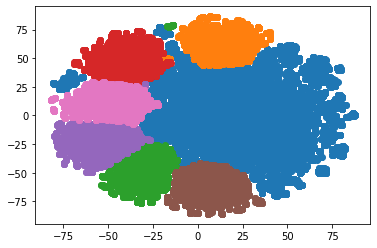

In [271]:
for c in np.unique(y):
# for c in [0]:
    ts2dc = ts2d[np.where(y == c)[0]]
    plt.scatter(ts2dc[:, 0], ts2dc[:, 1])

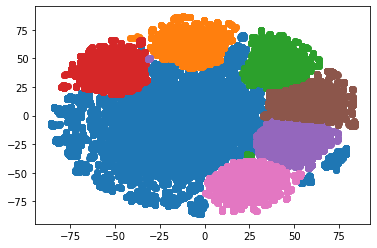

In [262]:
for c in np.unique(y):
# for c in [0]:
    ts2dc = ts2d[np.where(y == c)[0]]
    plt.scatter(ts2dc[:, 0], ts2dc[:, 1])

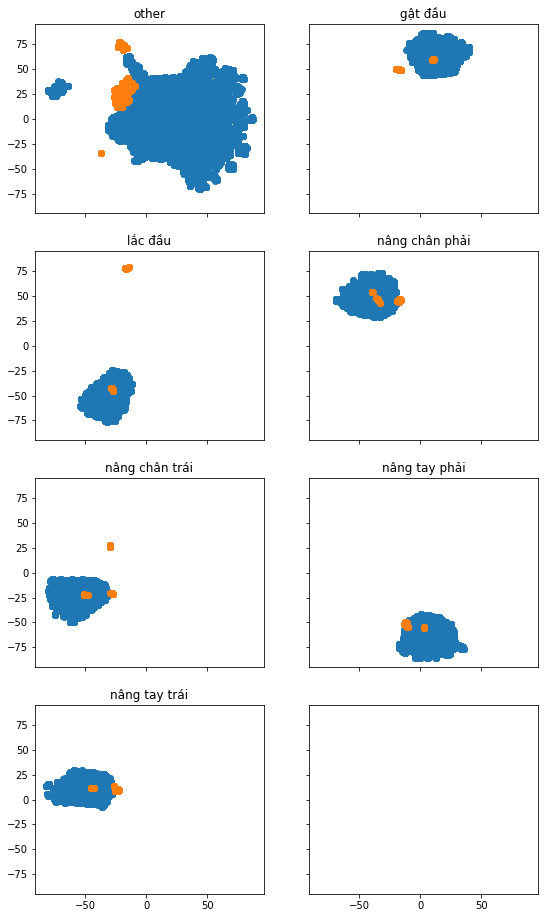

In [272]:
fig, axes = plt.subplots(nrows=len(np.unique(y)) // 2 + 1, ncols=2, sharex=True, sharey=True, figsize=(9,16))

for i, c in enumerate(np.unique(y)):
    axes[i // 2, i % 2].set_title(id_label[c])
    
    idx = np.where(y == c)[0]
    axes[i // 2, i % 2].scatter(ts2d[idx, 0], ts2d[idx, 1])
    
    tidx = np.array([i for i in idx if subj[i] == target_subject], dtype=int)
    axes[i // 2, i % 2].scatter(ts2d[tidx, 0], ts2d[tidx, 1])

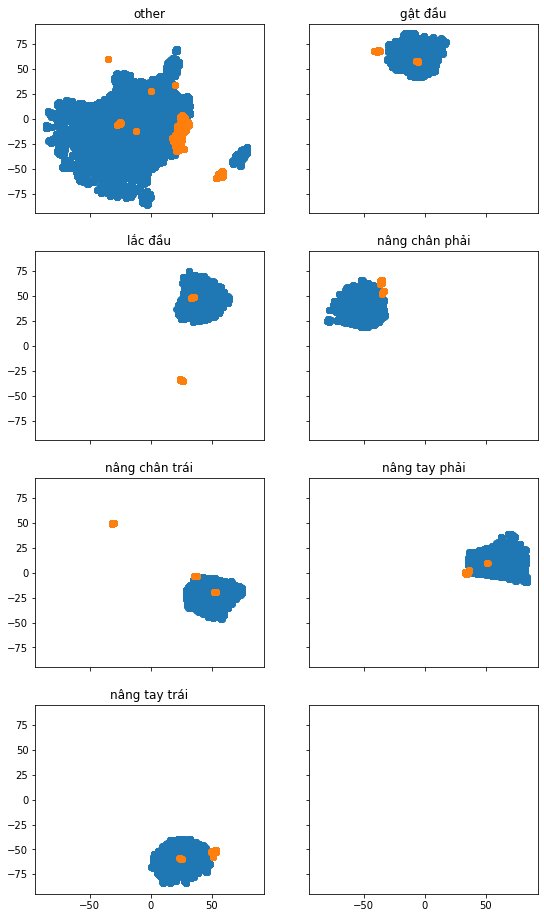

In [263]:
fig, axes = plt.subplots(nrows=len(np.unique(y)) // 2 + 1, ncols=2, sharex=True, sharey=True, figsize=(9,16))

for i, c in enumerate(np.unique(y)):
    axes[i // 2, i % 2].set_title(id_label[c])
    
    idx = np.where(y == c)[0]
    axes[i // 2, i % 2].scatter(ts2d[idx, 0], ts2d[idx, 1])
    
    tidx = np.array([i for i in idx if subj[i] == target_subject], dtype=int)
    axes[i // 2, i % 2].scatter(ts2d[tidx, 0], ts2d[tidx, 1])

In [68]:
target_label = "nâng tay phải"

target_label_ds_info = pd.concat([
    ds_info[(ds_info["subject"] == target_subject) & (ds_info["label"] == target_label) & (ds_info["trial"].isin(labeled_trials))],
    ds_info[(ds_info["subject"] != target_subject) & (ds_info["label"] == target_label)],
])

target_label_ds_info

,subject,scenario,event,label,trial,split,epochs
9,K309,nâng tay phải,Thinking,nâng tay phải,0,train,24
63,K311,nâng tay phải,Thinking,nâng tay phải,0,train,26
66,K311,nâng tay phải,Thinking,nâng tay phải,1,train,36
69,K311,nâng tay phải,Thinking,nâng tay phải,2,train,31
118,K312,nâng tay phải,Thinking,nâng tay phải,0,train,34
...,...,...,...,...,...,...,...
1443,K374,nâng tay phải,Thinking,nâng tay phải,1,train,28
1446,K374,nâng tay phải,Thinking,nâng tay phải,2,train,26
1488,K375,nâng tay phải,Thinking,nâng tay phải,0,train,23
1491,K375,nâng tay phải,Thinking,nâng tay phải,1,train,24


In [69]:
idx = list()
x = list()
y = list()
for i, r in target_label_ds_info.iterrows():
    idx.extend([i] * r["epochs"])
    x.append(aligned_ds.datasets[i].windows.get_data())
    y.extend(aligned_ds.datasets[i].y)
    
x = np.concatenate(x)
y = np.array(y, dtype=int)

len(idx), x.shape, y.shape

(2735, (2735, 32, 256), (2735,))

In [70]:
x = np.stack([np.cov(xi, rowvar=True) for xi in x])

x.shape

(2735, 32, 32)

In [72]:
potato = Potato(metric="riemann", threshold=2.5, n_iter_max=1000)  # mean +- threshold * std

In [73]:
%%time
potato.fit(x)

CPU times: user 2min 10s, sys: 4min 36s, total: 6min 46s
Wall time: 1min 8s


Potato(n_iter_max=1000, threshold=2.5)

In [74]:
pred = potato.predict(x).astype(int)

In [75]:
neg_idx = np.where(pred == 0)[0]
neg_idx

array([  36,   47,   48,   49,  103,  104,  105,  106,  107,  108,  644,
        664,  665,  666,  667,  668,  669,  670,  671,  672,  673,  674,
        675,  676,  677,  680,  681,  682,  683,  684,  685,  686,  687,
       1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215,
       1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1248,
       1249, 1250, 1251, 1252, 2122, 2123, 2124, 2125, 2126, 2127, 2146,
       2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155])

In [76]:
neg_row_idx = set([idx[i] for i in neg_idx])
neg_row_idx

{63, 69, 402, 403, 648, 650, 1140, 1143, 1189}

In [77]:
sorted(target_label_ds_info.loc[neg_row_idx]["subject"].unique())

/tmp/ipykernel_12173/1299999552.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted(target_label_ds_info.loc[neg_row_idx]["subject"].unique())


['K311', 'K322', 'K330', 'K366', 'K368']

In [78]:
target_epochs = aligned_ds.datasets[target_label_ds_info[target_label_ds_info["subject"] == target_subject].index[0]].windows

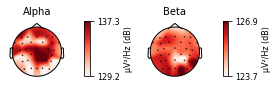

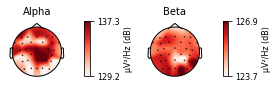

In [79]:
target_epochs.plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 32, "Beta")])

<AxesSubplot:>

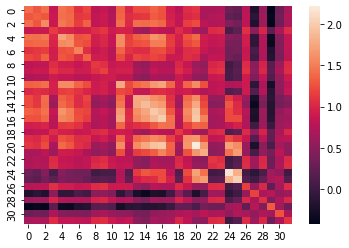

In [86]:
sb.heatmap(np.stack([np.cov(xi, rowvar=True) for xi in target_epochs.get_data()]).mean(axis=0))

In [80]:
outliner_epochs = aligned_ds.datasets[target_label_ds_info[target_label_ds_info["subject"] == "K311"].index[0]].windows

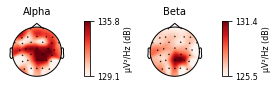

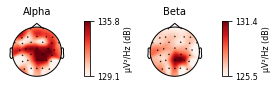

In [81]:
outliner_epochs.plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 32, "Beta")])

<AxesSubplot:>

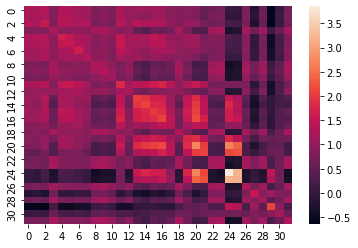

In [85]:
sb.heatmap(np.stack([np.cov(xi, rowvar=True) for xi in outliner_epochs.get_data()]).mean(axis=0))

In [82]:
aligned_epochs = aligned_ds.datasets[target_label_ds_info[target_label_ds_info["subject"] == "K315"].index[0]].windows

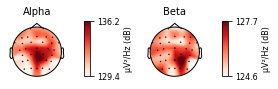

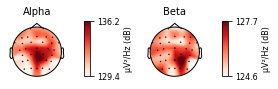

In [83]:
aligned_epochs.plot_psd_topomap(bands=[(8, 12, "Alpha"), (12, 32, "Beta")])

<AxesSubplot:>

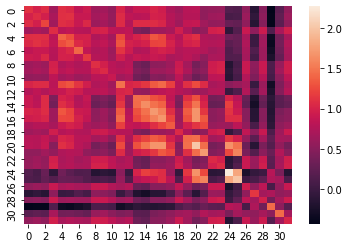

In [84]:
sb.heatmap(np.stack([np.cov(xi, rowvar=True) for xi in aligned_epochs.get_data()]).mean(axis=0))

In [28]:
rpf_config = {
    "alpha": {
        "l_freq": 8.0,
        "h_freq": 12.0,
    },
    "beta": {
        "l_freq": 12.0,
        "h_freq": 32.0,
    },
}

In [87]:
potato_field = PotatoField(n_potatoes=len(rpf_config), p_threshold=0.01, z_threshold=2.5, metric="riemann")

In [88]:
covs = list()
for config in rpf_config.values():
    config_covs = list()
    for i, r in target_label_ds_info.iterrows():
        epochs = aligned_ds.datasets[i].windows.copy().filter(l_freq=config["l_freq"], h_freq=config["h_freq"])
        config_covs.extend([np.cov(sig, rowvar=True) for sig in epochs.get_data()])
        
    covs.append(np.stack(config_covs))

In [89]:
%%time
potato_field.fit(covs)

CPU times: user 4min 8s, sys: 8min 37s, total: 12min 45s
Wall time: 2min 8s


PotatoField(n_potatoes=2, z_threshold=2.5)

In [90]:
neg_idx = np.where(potato_field.predict(covs).astype(int) == 0)[0]
neg_idx

array([  24,   47,   48,   49,   50,   92,  100,  103,  105,  106,  107,
        108,  109,  110,  111,  112,  113,  114,  211,  297,  298,  299,
        485,  552,  622,  633,  644,  646,  647,  648,  649,  664,  665,
        666,  667,  668,  669,  670,  671,  672,  673,  674,  675,  680,
        681,  682,  683,  684,  685,  686,  687, 1205, 1206, 1207, 1208,
       1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219,
       1220, 1221, 1222, 1223, 1224, 1225, 1242, 1243, 1248, 1249, 1250,
       1251, 1252, 1341, 1354, 1355, 1356, 1569, 2093, 2100, 2101, 2103,
       2105, 2118, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2130, 2134,
       2135, 2143, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2156, 2163,
       2179, 2183, 2185, 2209, 2239, 2252, 2290, 2294, 2419, 2427, 2429,
       2485])

In [91]:
neg_row_idx = set([idx[i] for i in neg_idx])
neg_row_idx

{63,
 66,
 69,
 171,
 177,
 285,
 339,
 400,
 402,
 403,
 648,
 649,
 650,
 674,
 793,
 1137,
 1140,
 1143,
 1189,
 1192,
 1195,
 1239,
 1242,
 1342,
 1348}

In [92]:
sorted(target_label_ds_info.loc[neg_row_idx]["subject"].unique())

/tmp/ipykernel_12173/1299999552.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sorted(target_label_ds_info.loc[neg_row_idx]["subject"].unique())


['K311',
 'K313',
 'K316',
 'K320',
 'K322',
 'K330',
 'K337',
 'K355',
 'K366',
 'K368',
 'K369',
 'K371']

In [292]:
import torch
from braindecode.augmentation import SmoothTimeMask, ChannelsDropout, GaussianNoise, Mixup

In [279]:
# transform = Compose([
#     ChannelsDropout(
#         probability=0.2,
#         p_drop=0.2,
#         random_state=42,
#     ),
#     GaussianNoise(
#         probability=0.5,
#         std=0.1,
#         random_state=42,
#     )
# ])

# transform = ChannelsDropout(probability=0.2, p_drop=0.2, random_state=42)
# transform = GaussianNoise(probability=0.5, std=0.2, random_state=42)
transform = Mixup(alpha=0.9, beta_per_sample=True, random_state=42)

In [285]:
x = np.concatenate([_ds.windows.get_data() for _ds in aligned_ds.datasets], axis=0)
y = np.concatenate([np.array(_ds.y, dtype=int) for _ds in aligned_ds.datasets], axis=0)
x.shape, y.shape

((34925, 32, 256), (34925,))

In [281]:
x_tr = transform.forward(x).cpu().numpy()

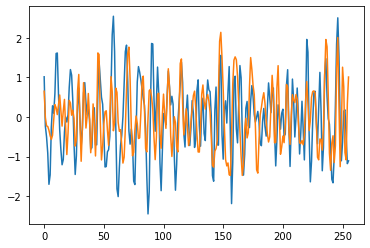

In [282]:
plt.plot(range(256), x[0, 10])
plt.plot(range(256), x_tr[0, 10])

In [288]:
idx = np.arange(len(y))
np.random.shuffle(idx)

x = x[idx]
y = y[idx]

In [293]:
x0 = torch.tensor(x[:100]).float()
y0 = torch.tensor(y[:100]).long()

transform.operation(x0, y0, **transform.get_params(x0, y0))

(tensor([[[-0.2483, -0.2278, -0.2214,  ...,  0.4700,  0.8163,  0.4628],
          [-0.6779, -0.0877,  0.3804,  ...,  0.1961,  1.1434,  1.0666],
          [-0.1935, -0.4791, -0.4814,  ...,  0.0643,  0.1759,  0.2432],
          ...,
          [ 0.6633,  0.7350,  0.5725,  ..., -0.5733, -1.2673, -1.2076],
          [ 0.6271,  0.4332,  0.1318,  ..., -0.1291, -0.8282, -0.9602],
          [ 0.0036,  0.0311, -0.1514,  ..., -0.6803,  0.0277,  0.0939]],
 
         [[ 0.8316, -0.1202, -1.3308,  ..., -0.0862, -0.8370, -0.0489],
          [-0.0579, -0.0529, -0.4320,  ..., -0.1608, -0.8809, -0.0454],
          [ 0.6283, -0.2073, -1.1099,  ..., -0.6620, -0.7201,  0.4131],
          ...,
          [-0.3355,  0.7122,  1.0095,  ..., -1.4577, -1.0650,  0.2979],
          [-0.3502, -0.3436, -0.3391,  ...,  0.0303, -0.7373, -0.8729],
          [-0.2289,  0.3830,  0.5938,  ..., -1.4084, -1.3268,  0.3136]],
 
         [[ 1.3217,  0.1886, -0.6214,  ...,  0.1164,  1.2831,  1.6025],
          [ 1.0378, -0.1686,